In [1]:
import torch
import yaml
import os
import sys
import matplotlib.pyplot as plt

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

from data_module import *
from evaluation_module import *
from forecast_module import *
from helpers import *
from observation_module import *
from tests.test_model import *
from visualisations import *

set_global_seed(42)

SCRIPT_DIR = os.getcwd()
sys.path.append(os.path.dirname(SCRIPT_DIR))
print(SCRIPT_DIR) 

path_to_plots = '../plots/'
path_to_results = '../results/'

EX_CONFIG = load_config(config_path = '../../configs/experiment_emulators.yaml')

network =  EX_CONFIG['network'] #'soil_TERENO_ISMN_2022.nc'#'soil_SMOSMANIA_ISMN_2022.nc' # 'soil_TERENO_ISMN_2022.nc'
station = EX_CONFIG['station'] # 'Lahas'
variable = EX_CONFIG['variable'] 
depth = EX_CONFIG['depth']  # [0.05, 0.2, 0.3]

years = EX_CONFIG['years']
models = EX_CONFIG['models']# , 'xgb'

maximum_leadtime = 100 # medium range, ten days

print("Network: ", network)
print("Station: ", station)
print("Variable: ", variable)
print("Depth: ", depth)
print("Years: ", years)
print("Models: ", models)
print("Initial time: ", EX_CONFIG['initial_time'])

/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator
cpu
/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator/notebooks
Opening ../../configs/experiment_emulators.yaml for experiment configuration.
Network:  soil_TERENO_ISMN_2022.nc
Station:  Gevenich
Variable:  st
Depth:  [0.05, 0.2, 0.5]
Years:  [2021, 2022]
Models:  ['mlp', 'lstm', 'xgb']
Initial time:  2022-01-10T00:00:00


/perm/pamw/venvs/myevalenv/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Select station:  Gevenich
Select depth:  [0.05, 0.2, 0.5]
Extracted year: 2022
Matched station with grid cell:  4106
Converting celsius into kelvin
Resampling to 6-hourly mean.


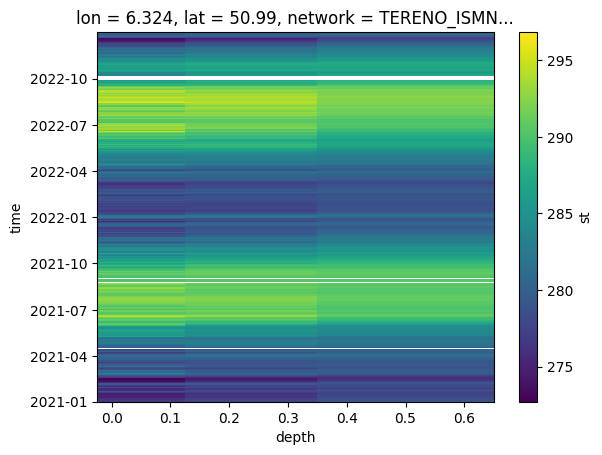

Length of data set: 2920


In [2]:
Gevenich = ObservationModule(network = network, 
                             station = station,
                             variable = variable,
                             depth=depth) # Initialise the Observation Module with the default Station (Gevenich)
GevenichPlots = VisualisationModule(network = network,
                                    station = station,
                                    variable = variable,
                                    maximum_leadtime=maximum_leadtime,
                                    path_to_plots=path_to_plots)

Gevenich.load_station(years = years) # Load two years of station data for lookback slicing
Gevenich.load_forcing() # Load forcing for matching data base with station data
closest_grid_cell = Gevenich.match_station_with_forcing() # Match the station with clostest grid cell and extract the index of the grid cell
station_data = Gevenich.process_station_data(path_to_plots = path_to_plots) 

In [3]:
CONFIG = load_config(config_path = '../../configs/lstm_emulator.yaml')
HPARS = load_hpars(use_model = '../lstm')

Opening ../../configs/lstm_emulator.yaml for experiment configuration.
{'clim_feats': ['clim_clake', 'clim_ldepth', 'clim_ctype', 'clim_cell_area', 'clim_glm', 'clim_cu', 'clim_cvh', 'clim_cvl', 'clim_tvh', 'clim_tvl', 'clim_sotype', 'clim_geopot', 'clim_sdfor', 'clim_sdor', 'clim_theta_cap', 'clim_theta_pwp', 'clim_veg_covh', 'clim_veg_covl', 'clim_veg_z0mh', 'clim_veg_z0ml', 'clim_veg_rsminh', 'clim_veg_rsminl'], 'dynamic_feats': ['met_ctpf', 'met_lwdown', 'met_psurf', 'met_qair', 'met_rainf', 'met_swdown', 'met_snowf', 'met_tair', 'met_wind_e', 'met_wind_n', 'lai_hv', 'lai_lv'], 'targets_prog': ['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc'], 'targets_diag': None, 'file_path': '/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr', 'start_year': 2015, 'end_year': 2019, 'validation_start': 2020, 'validation_end': 2020, 'test_start': 2021, 'test_end': 2022, 'x_slice_indices': [0, 'None'], 'spatial_sample_size': 300, 'path_to_boundingbox': None

In [4]:
ForecastModel = ForecastModuleLSTM(hpars=HPARS, config=CONFIG)

dataset = ForecastModel.initialise_dataset()
model = ForecastModel.load_model()
x_static, x_met, y_prog, y_prog_initialstate = ForecastModel.load_test_data(dataset)  

print(x_static.shape)
print(x_met.shape)
print(y_prog.shape)
print(y_prog_initialstate.shape)

Temporal start index 17408 Temporal end index 18743
Temporal lagged start index 17383
Length of dataset: 1335
Using a single grid cell
Spatial size of data set: 1
Spatial indices of data set: 4106
Use all x_idx from data set.
isint
torch.Size([23])
[11, 10, 13, 0, 14, 12, 4, 3, 6, 5, 7, 2, 9, 8, 16, 15, 20, 19, 22, 21, 18, 17]
torch.Size([22])
torch.Size([1, 1, 22])
Set up model
Load model from checkpoint:  ../lstm/checkpoints/best-model-epoch=92-val_loss=0.00.ckpt
Matched keys
Select one grid cell from data
Model to device: cpu
torch.Size([1, 1, 22])
torch.Size([1360, 1, 12])
torch.Size([1360, 1, 7])
torch.Size([24, 1, 7])


Selecting from index: 1496
Subtract lookback for new index: 1472


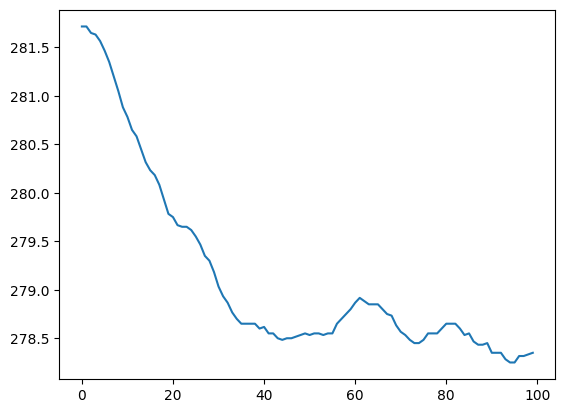

In [5]:
station_data = Gevenich.slice_station_data(lookback=CONFIG["lookback"],
                                t_0=EX_CONFIG['initial_time'])

plt.plot(station_data[:100,0,2])

In [8]:
#y_prog_hybrid = y_prog.clone()
station_data = Gevenich.slice_station_data(lookback=CONFIG["lookback"],
                                t_0=EX_CONFIG['initial_time'])
station_data_nolb = Gevenich.slice_station_data(lookback=0,
                                t_0=EX_CONFIG['initial_time'])
print("STATION DATA SHAPE", station_data.shape)
matching_indices = Gevenich.match_indices(dataset=dataset,
                                              target_variables=EX_CONFIG['targets_eval'])
print("MATCHING INDICES", matching_indices)
y_prog_initialstate[..., matching_indices] = station_data[:y_prog_initialstate.shape[0]]
print("YPROG INITIAL SHAPE", y_prog_initialstate.shape)
print("YPROG INITIAL SHAPE", y_prog_initialstate[:CONFIG["lookback"]])


matching_indices = Gevenich.match_indices(dataset=dataset,
                                              target_variables=EX_CONFIG['targets_prog'])
initial_vector =  Gevenich.transform_initial_vector(station_data = y_prog_initialstate, 
                                                  matching_indices = matching_indices)
print("INITIAL VECTOR SHAPE", initial_vector)
dynamic_features, dynamic_features_prediction = ForecastModel.run_forecast(initial_conditions=initial_vector)
dynamic_features, dynamic_features_prediction = ForecastModel.backtransformation()

Selecting from index: 1496
Subtract lookback for new index: 1472
Selecting from index: 1496
Subtract lookback for new index: 1496
STATION DATA SHAPE torch.Size([1448, 1, 3])
MATCHING INDICES [3, 4, 5]
YPROG INITIAL SHAPE torch.Size([24, 1, 7])
YPROG INITIAL SHAPE tensor([[[4.0253e-01, 3.9822e-01, 3.7025e-01, 2.8135e+02, 2.8182e+02,
          2.8172e+02, 1.6992e-01]],

        [[3.9572e-01, 3.9752e-01, 3.7076e-01, 2.8120e+02, 2.8162e+02,
          2.8172e+02, 1.7773e-01]],

        [[3.9122e-01, 3.9632e-01, 3.7122e-01, 2.8107e+02, 2.8150e+02,
          2.8165e+02, 1.2305e-01]],

        [[3.8765e-01, 3.9493e-01, 3.7163e-01, 2.8047e+02, 2.8145e+02,
          2.8163e+02, 6.2500e-02]],

        [[3.8550e-01, 3.9349e-01, 3.7198e-01, 2.7928e+02, 2.8112e+02,
          2.8157e+02, 2.3438e-02]],

        [[4.0201e-01, 3.9323e-01, 3.7230e-01, 2.7843e+02, 2.8065e+02,
          2.8147e+02, 0.0000e+00]],

        [[3.9851e-01, 3.9412e-01, 3.7262e-01, 2.7860e+02, 2.8030e+02,
          2.8135e+02, 0.

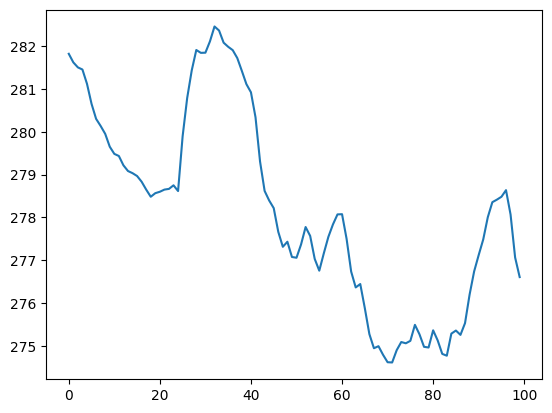

In [10]:

plt.plot(dynamic_features_prediction[:100,0,4])


torch.Size([24, 1, 7])
torch.Size([1, 1336, 1, 7])
torch.Size([1360, 1, 7])
torch.Size([1360, 1, 7])
torch.Size([1448, 1, 3])
[3, 4, 5]


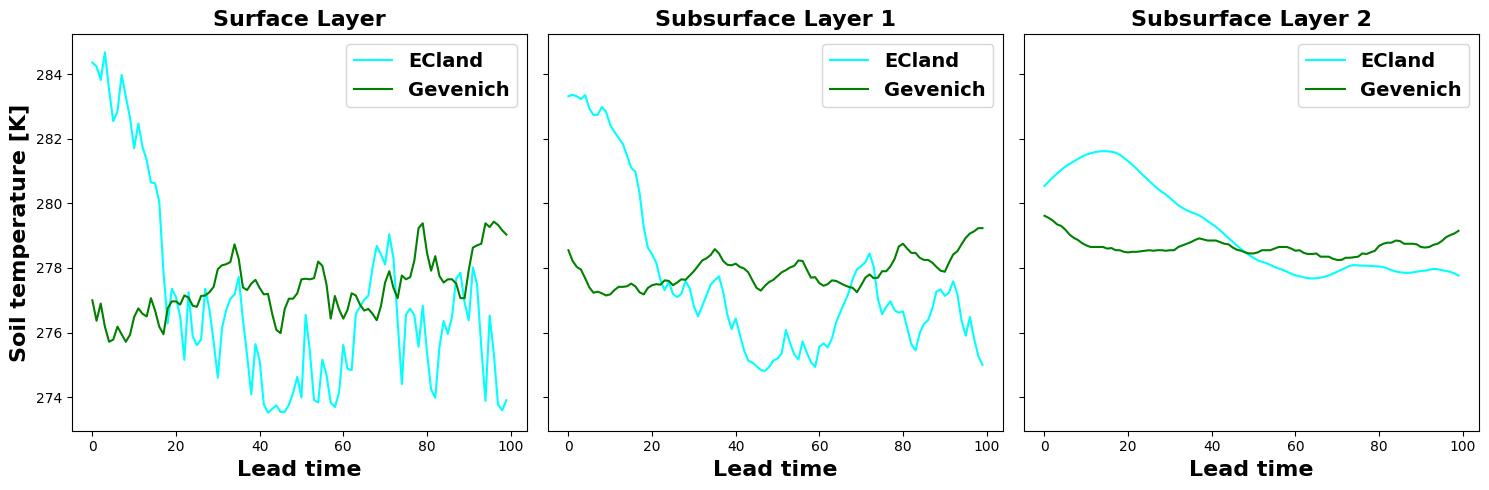

In [12]:
print(y_prog_initialstate.shape)
print(ForecastModel.preds.shape)
print(dynamic_features.shape)
print(dynamic_features_prediction.shape)
print(station_data.shape)

matching_indices = Gevenich.match_indices(dataset=dataset,
                                              target_variables=EX_CONFIG['targets_eval'])

print(matching_indices)
GevenichPlots.plot_station_data(dynamic_features[CONFIG['lookback']:], station_data[CONFIG['lookback']:], 
                                matching_indices= matching_indices)

In [14]:
print(y_prog_initialstate.shape)
y_prog_initialstate[:1]

torch.Size([1, 7])


tensor([[4.0253e-01, 3.9822e-01, 3.7025e-01, 2.7682e+02, 2.7820e+02, 2.7933e+02,
         1.6992e-01]])